# Multichannel stiching

Example showing how multichannel data can be stiched.


In [1]:
import configparser
import os.path
from alpenglow.image_sources.s3 import S3ImageSource

path_format = '/skin660_488_reflectance/skin{stripe_id:01d}/skin{stripe_id:01d}_{version_id:05d}.tif'
stripe_ids = [1, 2, 3]
version_ids = list(range(1, 4201))

config_parser = configparser.ConfigParser()
config_parser.read_file(open(os.path.join(os.path.expanduser('~'), '.aws', 'credentials')))
config_parser.sections()

aws_access_key_id = config_parser.get('default', 'AWS_ACCESS_KEY_ID')
aws_secret_access_key = config_parser.get('default', 'AWS_SECRET_ACCESS_KEY')

def image_mapping(stripe_id, version_id):
    return (stripe_id, version_id if stripe_id % 2 == 1 else 4201 - version_id)

image_source = S3ImageSource(path_format, stripe_ids, version_ids, aws_access_key_id, aws_secret_access_key, 'alpenglowoptics', 'https://s3.amazonaws.com', mapping=image_mapping, channel_count=2)
print("configuration read")

configuration read


## Data preview

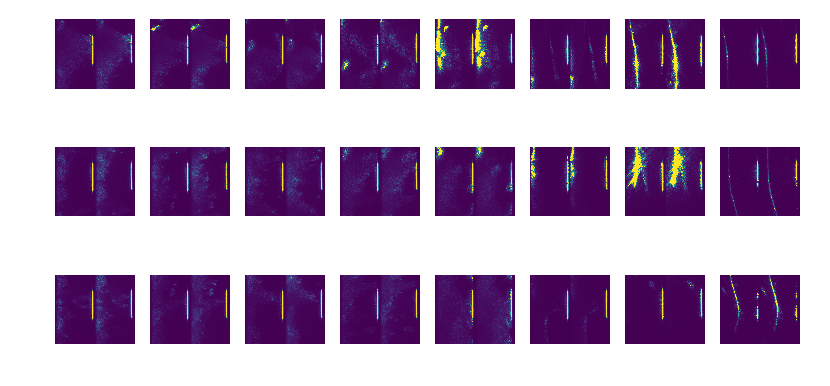

Average sample fetch time: 0.2692970434824626
estimated required time 3393.1427478790283


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import concurrent

from time import time
start_time=time()

demo_versions = [1, 512, 1024, 1536, 2048, 2560, 3072, 3584]
stripe_count = len(stripe_ids)

fig = plt.figure(figsize=(8, 4), dpi=120)
future_to_position = {}
for version_index, version_id in enumerate(demo_versions, 1):
    for stripe_id in range(len(stripe_ids)):
        future_to_position[image_source.get_image_future(stripe_id, version_id)] = version_index + len(demo_versions) * stripe_id
        
for future in concurrent.futures.as_completed(future_to_position):
    ax = fig.add_subplot(stripe_count, len(demo_versions), future_to_position[future])
    ax.imshow(future.result())
    ax.set_axis_off()
plt.show()

avg_image_fetch_time = (time() - start_time)/(len(demo_versions) * stripe_count)
print("Average sample fetch time: {0}\nestimated required time {1}".format(avg_image_fetch_time, avg_image_fetch_time * stripe_count * len(version_ids)))

## Finding shift preview


In [3]:
from alpenglow.matching_algorithms.fft import FftMatchingAlgorithm
matching_algorithm = FftMatchingAlgorithm(list(range(0, 4200, 100)), [0, 1])

print(matching_algorithm.match(image_source.get_stripe(0), image_source.get_stripe(1)))

[314  -1]


In [4]:
image_source.get_image(0, 0).shape

(900, 1024)

In [5]:
from alpenglow.patchwork_builders.default import PatchworkBuilder
from alpenglow.image_sources.benchmarking import BenchmarkingImageSource

benchmarking_image_source = BenchmarkingImageSource(image_source)
from time import time
start_time=time()

builder = PatchworkBuilder(matching_algorithm)
for stripe_id in range(3):
    builder.stitch(benchmarking_image_source.get_stripe(stripe_id))
    
patchwork = builder.get()

print("total time: {0}s".format(time() - start_time))
stitching_times, result_building_time = builder.benchmark()
print("stitching times: {0}\nresult_building: {1}s".format(stitching_times, result_building_time))
print("image fetching time: {0}".format(benchmarking_image_source.total_fetching_time()))


%matplotlib inline
fig = plt.figure(figsize=(8, 4), dpi=120)
for version_index, version_id in enumerate([1, 512, 1024, 1536, 2048, 2560, 3072, 3584]):
    ax = fig.add_subplot(1, 8, 1 + version_index)
    ax.imshow(patchwork.get_channel_image(version_id - 1, 0))
    ax.set_axis_off()
    

KeyboardInterrupt: 

## Second channel

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(8, 4), dpi=120)
for version_index, version_id in enumerate([1, 512, 1024, 1536, 2048, 2560, 3072, 3584]):
    ax = fig.add_subplot(1, 8, 1 + version_index)
    ax.imshow(patchwork.get_channel_image(version_id - 1, 1))
    ax.set_axis_off()